## **Dataset visualization and extraction from ESRF .h5 files**
- Version: 1.2 | Author: William Rigaut | Date: 26.11.2024
- Tested on MacOS Ventura 13.4.1 and Python 3.12.3

This code is designed to extract and visualize data from the European Synchrotron Radiation Facility (ESRF) at beamline BM02.

The module contains:
- Functions for extracting and visualizing data from the raw .h5data files
- Functions for extracting and visualizing data from the processed .h5 files
- Functions for saving data to .xy files

### **1. Import library and setup**

Firstly you can create a set of folders where your data will be stored and extracted. I recommand creating a main folder called `ESRF_data` containing three subfolder :
- `RAW_DATA` : Folder contaning the raw XRD data from the 2D camera
- `PROCESSED_DATA` : Folder containing the 1D spectra from integrated 2D images
- `SAVED_DATA` : Output folder containing .xy 1D spectra for each position

In [29]:
# Defining our paths with pathlib librairy
import pathlib as pl

main_folder = "ESRF_data"

raw_data_path = pl.Path(main_folder + '/' + "RAW_DATA")
processed_data_path = pl.Path(main_folder + '/' + "PROCESSED_DATA")
saved_data_path = pl.Path(main_folder + '/' "SAVED_DATA")

Then you can import the package `extract_esrf` to create these folders for you with :

In [30]:
# Making folders with create_folders() function from extract_esrf library
import packages.extract_esrf.extract_esrf as ee

ee.create_folders(main_folder,
                  raw_data_path, processed_data_path, saved_data_path)

Creating folder ESRF_data
Folder ESRF_data already exists.
Creating folder ESRF_data/RAW_DATA
Folder ESRF_data/RAW_DATA already exists.
Creating folder ESRF_data/PROCESSED_DATA
Folder ESRF_data/PROCESSED_DATA already exists.
Creating folder ESRF_data/SAVED_DATA
Folder ESRF_data/SAVED_DATA already exists.


Now that everything is setup you can download or import your raw data files from ESRF in the `RAW_DATA/` and `PROCESSED_DATA/` directories.

<span style="color: red;">Disclamer: You need to have both raw and processed data in order for the notebook to run properly.</span>

### **2. Data visualization and data extraction**

You can define the variable `foldername` to be the folder that contains the data you want to see, here is an example with NdFeB_7-17 dataset for the scan number 31:

In [31]:
foldername="CeCoZn_4_3"
scan_number=30

Then you can call the function `extract_CdTe_data()` by specifiying both the foldername and the scan_number in argument. A few details about this function :
- The function actually returns an array containing the count on each pixel of the 2D camera. You can eventually save the content of image_2D if needed.
- You can disable the plotting by setting display to False with the code `ee.extract_CdTe_data(foldername, scan_number, display=False)`.
- If you are using a path for the raw data that is different from the one previously suggested you must pass in argument `raw_data_path=your_custom_path` so that the function knows where to look for the data.
- Note that in the 2D camera datasets, the first 26 scans are corresponding to z and theta alignements along the wafer, the first acquired position starts at `scan_number=27` and the last at `scan_number=315`.

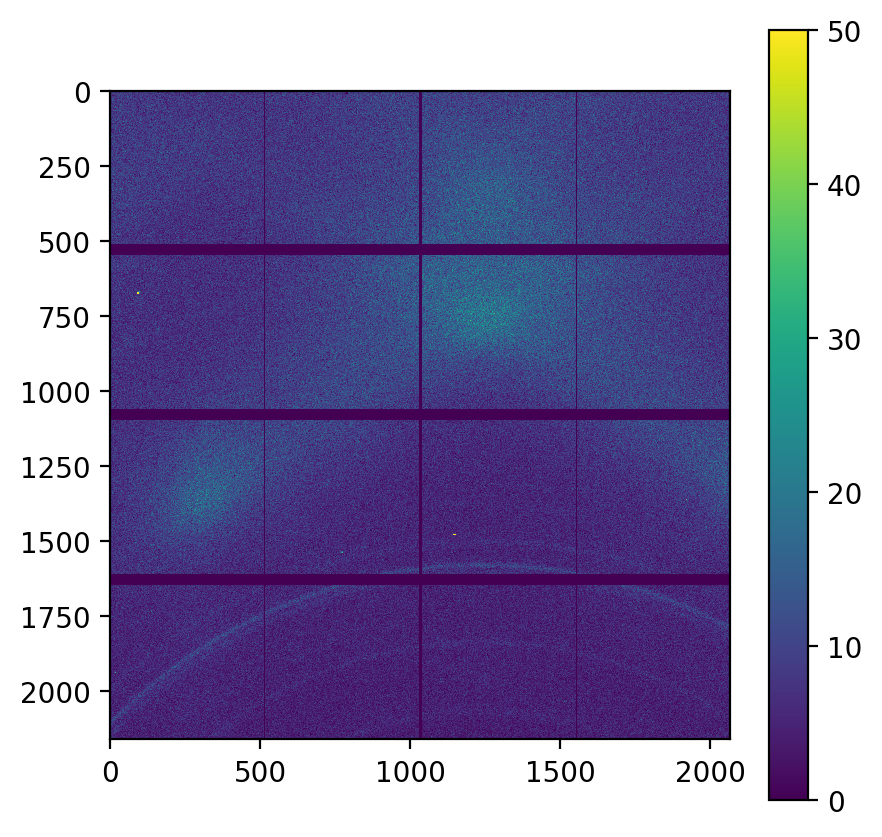

In [32]:
image_2D, metadata = ee.extract_CdTe_data(foldername, scan_number, display=True, output_metadata=True, raw_data_path=raw_data_path)

A very similar `function extract_integrated_data()` can be used to display the 1D integrated image data like this :

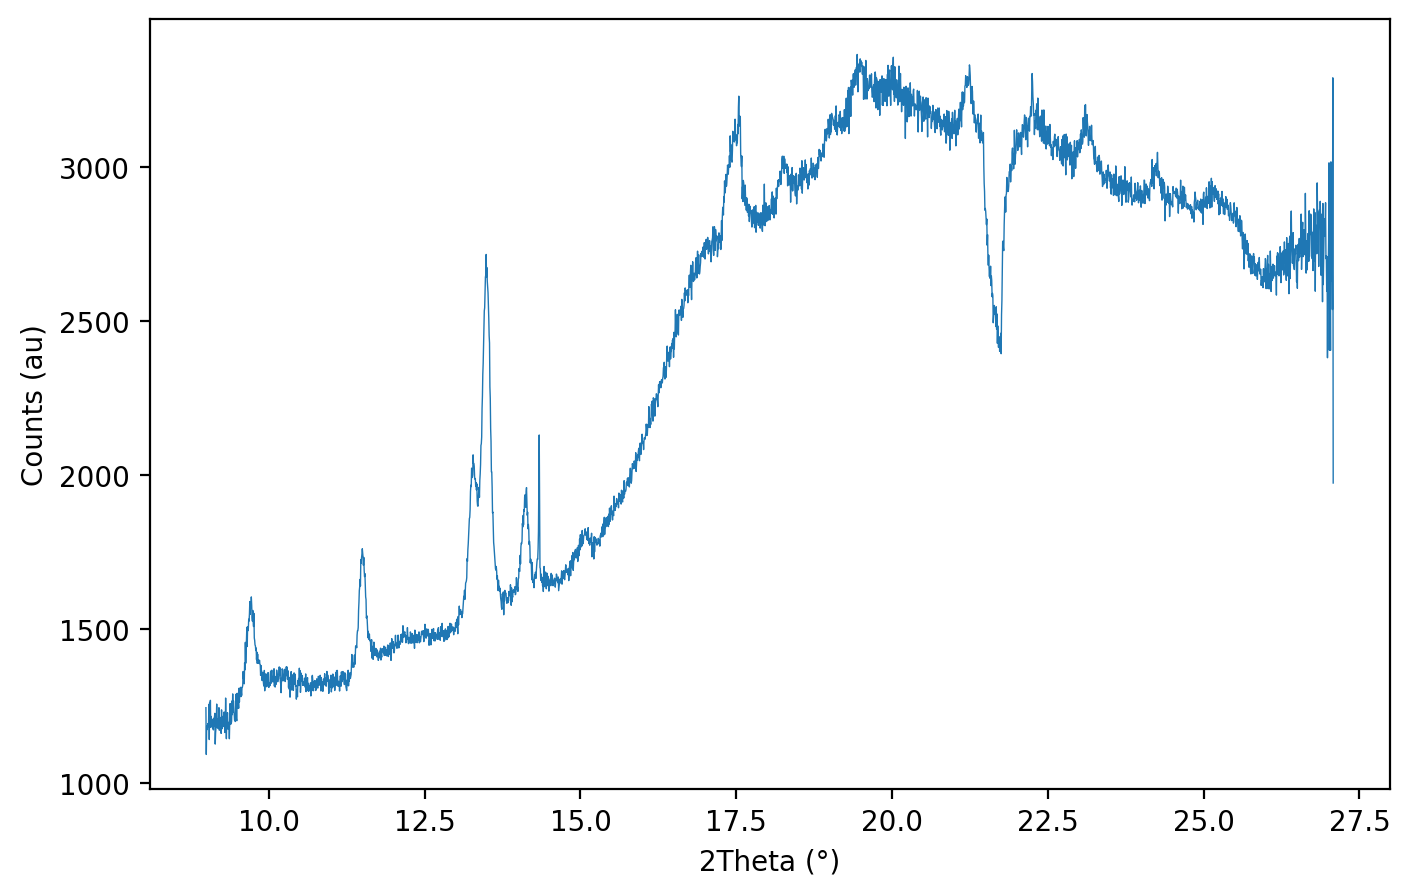

In [33]:
spectra_1D = ee.extract_integrated_data(foldername, scan_number, display=True, processed_data_path=processed_data_path)

You can then simply save the spectra using the function `save_integrated_data()` by passing first both the `foldername` and the `scan_number` as argument to generate a .xy file with a proper filename and then the `spectra_1D` you want to save. A few points :
- The x values saved are q values (in Å^-1) converted to 2θ angle by knowing the beam energy (25 keV).
- In the .h5 integrated data, counts at each angle are calculated by summing all the pixels intensities and normalized by the total number of pixels. In the library, the y values are arbitrary rescaled with a factor of 1000 to make it easier to read in Profex. The final unit for the counts should be counts/pixel*10^3.

In [6]:
ee.save_integrated_data(foldername, scan_number, spectra_1D, saved_data_path=saved_data_path)

If you want to save all the data from the dataset (excluding the calibration points) you can use instead `save_all_integrated()` by specifiying the `foldername` and all three paths `raw_data_path`, `processed_data_path`, `saved_data_path` to the function.

- The function will read all the scans from number 27 to 315 (25 to 274 for new scans), excluding the z and theta scans from calibration
- Metadata is copied from the raw data fils and written in the header of each .xy files.

In [34]:
ee.save_all_integrated(foldername,
    raw_data_path=raw_data_path,
    processed_data_path=processed_data_path,
    saved_data_path=saved_data_path,
    custom_range=range(25, 274))

100%|██████████| 249/249 [00:52<00:00,  4.73it/s]

All .xy spectrum saved in ESRF_data/SAVED_DATA/CeCoZn_4_3 succesfully !


The same can be done with the images using the function `save_all_images()` where you need to pass in arguments the `foldername`, the `raw_data_path` and the `savec_data_path`.

- By default the function will only read measurement data which includes scans from number 27 to 315, but a `custom_range` can be specified using the `range(start, stop)` function.
- The image is saved using the FabIO library, and his saved as .img by default. Format can be changed with the `custom_format` parameter. A list of all FabIO compatible formats can be found here: http://www.silx.org/doc/fabio/latest/getting_started.html#list-of-file-formats-that-fabio-can-read-and-write

In [35]:
ee.save_all_images(
    foldername,
    raw_data_path=raw_data_path,
    saved_data_path=saved_data_path,
    custom_range=range(25, 274))

100%|██████████| 249/249 [00:51<00:00,  4.85it/s]

All CdTe data saved in ESRF_data/SAVED_DATA/CeCoZn_4_3 succesfully !


You can then read the .img files using the `fabio` python module. Here is a advanced example using interactive sliders to display images:

In [36]:
import packages.extract_esrf.extract_esrf as ee

folderpath_str = "ESRF_data/SAVED_DATA//CeCoZn_4_3"

ee.display_all_img(folderpath_str, index=117, scale="normal", aspect="1")

interactive(children=(IntSlider(value=117, description='index', max=273, min=25), IntSlider(value=0, descripti…

The follwing function `fuse_all_img()` will merge all of the images in a folder. You can customize the selection with the argument `idx_range`, default value is `range(25, 274)`
- You can use this following code to plot the fused image :

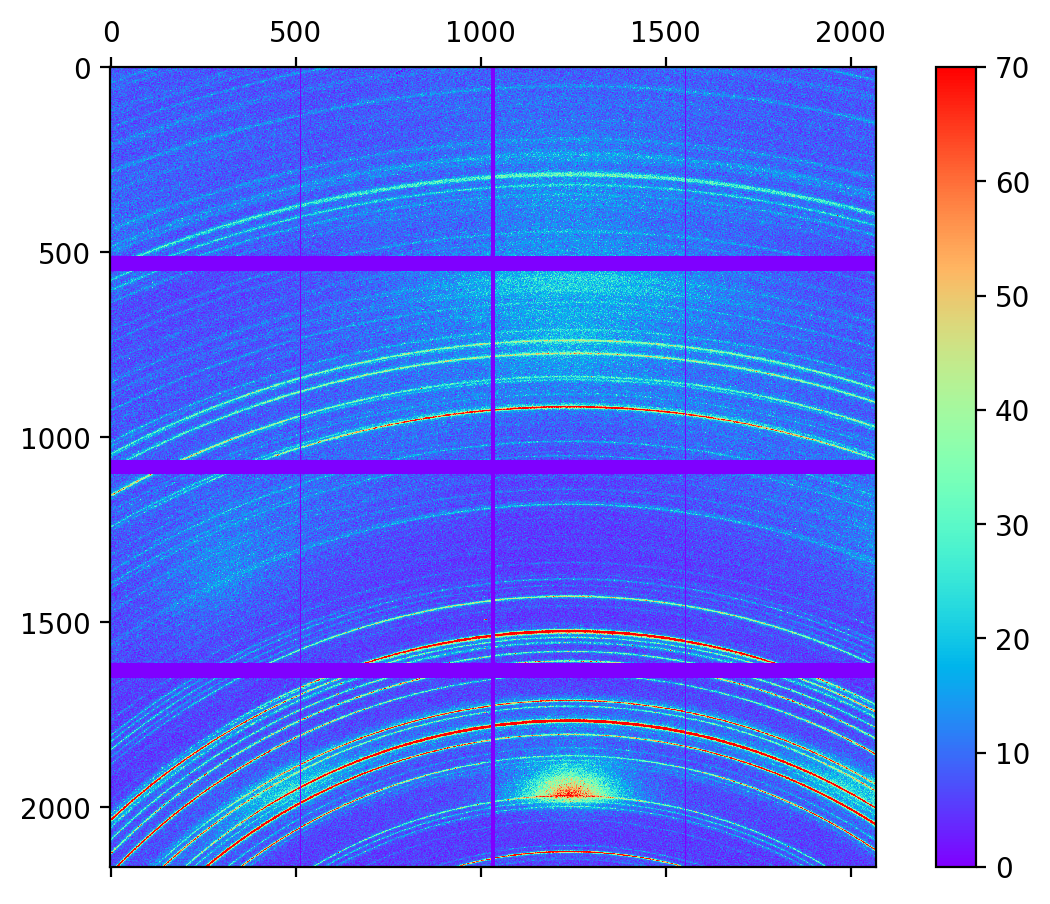

In [38]:
import packages.extract_esrf.extract_esrf as ee

fused_img = ee.fuse_all_img(folderpath_str, idx_range=range(25, 274))
img_data_current = ee.plot_img("ESRF_data/SAVED_DATA/NdXFeB-triode/3161_NdFeB", index=193, plot=False)
img_data_current_2 = ee.plot_img("ESRF_data/SAVED_DATA/NdXFeB-triode/3161_NdFeB", index=200, plot=False)
ee.plot_img('_', '_', img_data=img_data_current_2, vmin=0, vmax=70, scale="normal", aspect="1")

The following code is a very first version to redo the 1D integration while filtering the Al peaks. You will need to extract the .img files and get the .poni file to perform the 1D integration.

<span style="color: red;">Disclamer: Please check the integration and make sure nothing went wrong during the process..</span>

In [40]:
# Imports
import packages.extract_esrf.extract_esrf as ee
import pathlib as pl
import os, fabio, pyFAI
from tqdm import tqdm
os.environ["PYOPENCL_COMPILER_OUTPUT"]="0"

# Defining our paths 
main_folder = "ESRF_data"
foldername = "CeCoZn_4_3"
saved_data_path_filtered = f"./{main_folder}/SAVED_DATA/NdXFeB-magnetron/{foldername}/"
processed_data_path = pl.Path(f"{main_folder}/PROCESSED_DATA/")
ee.create_folders(main_folder, saved_data_path_filtered)

# Getting the poni file from ESRF to perform the integration
ai = pyFAI.load("/Users/williamrigaut/Desktop/Notebooks/Extract_ESRF_Data/ESRF_data/CONFIG/LaB6_25keV_20250501.poni")
# Filtering parameters, you can let that untouched
method = ["full", "csr", "cython"]
filter_name = "Median filtering"
percentile=(40,60)
pol=0.99

# Loop on all the images
for scan_number in tqdm(range(25, 274)):
    # Open the img file
    img = fabio.open(f"{saved_data_path_filtered}/{foldername}_{scan_number}.img").data
    # 1D integration using the median filter method
    plot1d = ai.medfilt1d_ng(img, 3000, method=method, percentile=percentile, polarization_factor=pol)
    # Getting the two theta and intensities
    tth_list = ee._convert_from_q_to_theta(plot1d[0]/10, wavelength=0.495937)
    intensity_list = plot1d[1]*1000
    data = (tth_list, intensity_list)

    # Save the 1D data in both .xy files and directly inside the hdf5 processed data file.
    ee.save_integrated_data(foldername, scan_number, data, save_metadata=True, raw_data_path="./ESRF_data/RAW_DATA/", saved_data_path=saved_data_path_filtered)
    ee.rewrite_to_hdf5(processed_data_path=processed_data_path, foldername=foldername, scan_number=scan_number, data=data, filter_name=filter_name)
    


Creating folder ESRF_data
Folder ESRF_data already exists.
Creating folder ./ESRF_data/SAVED_DATA/NdXFeB-magnetron/CeCoZn_4_3/
Folder ./ESRF_data/SAVED_DATA/NdXFeB-magnetron/CeCoZn_4_3/ already exists.


100%|██████████| 249/249 [05:56<00:00,  1.43s/it]


---

In [ ]:
# Old try to identify outliers with Z score method directly on the image, but not finished and other method seems more reliable
from scipy import stats
import numpy as np

z_score = np.abs(stats.zscore(img_data_current))
z_score_2 = np.abs(stats.zscore(img_data_current_2))

z_score /= np.nanmax(z_score)
z_score_2 /= np.nanmax(z_score_2)

print(np.nanmax(z_score))
print(np.nanmax(z_score_2))

ee.plot_img('_', '_', img_data=z_score, vmin=0.0, vmax=1.0, scale="normal", aspect="1")
ee.plot_img('_', '_', img_data=z_score_2, vmin=0.0, vmax=1.0, scale="normal", aspect="1")


def create_disk(center_coordinates, radius=10):
    circle = []
    for i in range(center_coordinates[0]-radius, center_coordinates[0]+radius):
        for j in range(center_coordinates[1]-radius, center_coordinates[1]+radius):
            if (i-center_coordinates[0])**2+(j-center_coordinates[1])**2 <= radius**2:
                circle.append((i,j))
    return circle


def fill_mask(mask, circle, value):
    for i,j in circle:
        # Check if coordinate is in mask
        if i <= 0 or i > mask.shape[0] or j <= 0 or j > mask.shape[1]:
            continue
        mask[i][j] = value
    
    return mask


def create_mask(img_data_current, z_score, value=1, threshold=0.2):
    mask = np.zeros(img_data_current.shape)
    center_coordinate_list = []

    for i in range(img_data_current.shape[0]):
        for j in range(img_data_current.shape[1]):
            if z_score[i][j] > threshold:
                center_coordinates = (i, j)
                circle = create_disk(center_coordinates)
                mask = fill_mask(mask, circle, value=value)
                center_coordinate_list.append(center_coordinates)

    return mask, center_coordinate_list


ee.plot_img('_', '_', img_data=img_data_current_2, vmin=0.0, vmax=50.0, scale="normal", aspect="1")
mask, center_coordinate_list = create_mask(img_data_current_2, z_score_2, value=10, threshold=0.5)
ee.plot_img('_', '_', img_data=mask, vmin=0.0, vmax=10, scale="normal", aspect="1")

In [ ]:
import xrayutilities as xu


sample_rotation = ['y-','x+','z-']# omega, chi @ eta = 0, phi @ chi = 0
detector_rotation = ['y-','z-'] # 2th, 2thChi
beam_direction = [1,0,0]

qconv = xu.experiment.QConversion(sample_rotation, detector_rotation, beam_direction)
print(qconv)

# ENERGY
wavelength = 0.495937
energy = 12398.4/wavelength

# FIRST DIRECTION TO DEFINE WHICH Q COMPONENT ALONG XRAYS
# [xdir1, ydir1, zdir1] orientation along beam direction
all_zero_Orientation_In_Beam_Direction = [1,0,0]

# SECOND DIRECTION TO DEFINE WHICH Q COMPONENT PERP AND IN SCATTERING PLANE
# FOR INSTANCE : along surface normal for a film
# [xnormal,ynormal,znormal] orientation perp, in scattering plane
all_zero_Orientation_Perp_In_Scattering_Plane = [0,0,1]

# call HXRD method 
hxrd=xu.HXRD(all_zero_Orientation_In_Beam_Direction,
             all_zero_Orientation_Perp_In_Scattering_Plane,
             en=energy,
             qconv=qconv)
print(hxrd)

QConversion geometry 
---------------------------
sample geometry(3): y-x+z-
detector geometry(2): y-z-
primary beam direction: ( 1.00  0.00  0.00) 

scattering plane normal: (0.000000 -1.000000 0.000000)
inplane azimuth: (1.000000 0.000000 0.000000)
second refercence direction: (0.000000 0.000000 1.000000)
energy: 24999.949590 (eV)
wavelength: 0.495938 (angstrom)
QConversion geometry 
---------------------------
sample geometry(3): y-x+z-
detector geometry(2): y-z-
primary beam direction: ( 1.00  0.00  0.00) 



In [ ]:
omega, tth, tthchi = 45, 90, 0
print('Q is ', hxrd.Ang2Q(omega, chi, phi, tth, tthchi))
# should be along Qz

Q is  (np.float64(0.0), np.float64(0.0), np.float64(17.917097645265336))


In [ ]:
import pyFAI

# here we enter specifics about the set-up
# nb of pixels hor, vert and size in [m]
Npx_h, Npx_v = 2068, 2162
pix_width_h  = 7.5e-05
pix_width_v  = 7.5e-05

# get center and distance from poni file
ai = pyFAI.load("/Users/williamrigaut/Desktop/Notebooks/Extract_ESRF_Data/ESRF_data/CONFIG/LaB6_25keV_20250501.poni")
distance     = ai.dist
c1           = ai.get_poni2()/pix_width_h
c2           = ai.get_poni1()/pix_width_v

print('Center is ', c1, c2)
print('Distance is ', distance)

#### DATA SAMPLING
nav  = [1,1] #For data reduction in the two directions
xmin, xmax, ymin, ymax = 0, Npx_h, 0, Npx_v
# ROI ?
roi = [xmin, xmax, ymin, ymax]

Center is  1214.2195044428963 2035.8118402416567
Distance is  0.5479069521977671


In [ ]:
# init_area() calculates the position in space of each and every pixels
hxrd.Ang2Q.init_area('y-', 'z-', 
                    cch1=c1, cch2=c2,
                    Nch1 = Npx_h, Nch2 = Npx_v, 
                    pwidth1=pix_width_h, pwidth2=pix_width_v,
                    distance=distance,
                    Nav=nav,
                    roi=roi)

In [ ]:
# x along x-rays, z vertical, y right referential
omega, chi, phi, tth, tthchi = 0, 0, 0, 0, 0
qx, qy, qz = hxrd.Ang2Q.area(omega,chi,phi,tth,tthchi) # omega, chi, phi, tth, tthchi

In [ ]:
# retrieving the size of the detector
print(qx.shape, qy.shape, qz.shape)
# some q values, a random pixel [12,189]
print(qx[0,0], qy[0,0], qz[0,0])

(2068, 2162) (2068, 2162) (2068, 2162)
-0.6184985510957225 2.002938585019492 3.3582116509736215


1.9803862014989626
6.0002961388005565
4.974394645509082


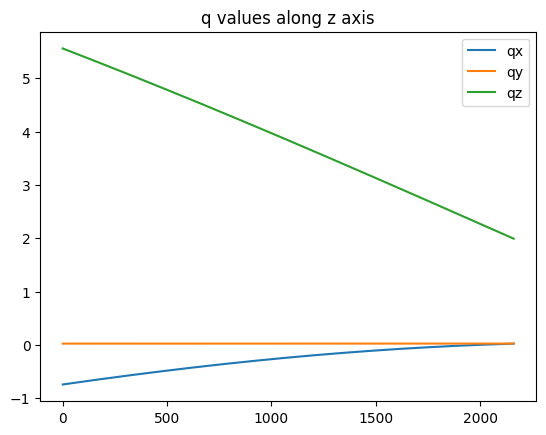

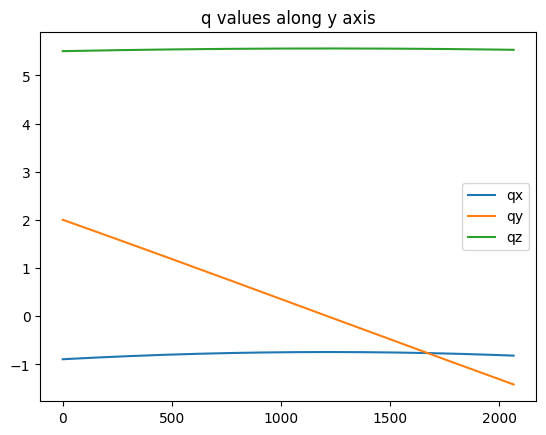

In [ ]:
#instrument/positioners_end/th: 5.177382010956184 (omega)
#instrument/positioners_end/tth: 9.99967981196768 (tth)

omega, chi, phi, tth, tthchi = 5.1774, 0, 0, 9.9997, 0
qx, qy, qz = hxrd.Ang2Q.area(omega, chi, phi, tth, tthchi)

def calculate_q_norm(qx, qy, qz):
    q = np.sqrt(qx**2 + qy**2 + qz**2)
    return q

# checking min and max q of the 2D image
print(calculate_q_norm(np.abs(qx).min(), np.abs(qy).min(), np.abs(qz).min()))
print(calculate_q_norm(np.abs(qx).max(), np.abs(qy).max(), np.abs(qz).max()))

print(calculate_q_norm(qx[2000,500], qy[2000,500], qz[2000,500]))

plt.title("q values along z axis") 
plt.plot(qx[1200,:], label="qx")
plt.plot(qy[1200,:], label="qy")
plt.plot(qz[1200,:], label="qz")
plt.legend()
plt.show()

plt.title("q values along y axis") 
plt.plot(qx[:,0], label="qx")
plt.plot(qy[:,0], label="qy")
plt.plot(qz[:,0], label="qz")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

Al_cubic = xu.materials.Al
print(Al_cubic)

tt = np.arange(7.5, 27.5, 0.01)

Al_powder = xu.simpack.Powder(Al_cubic, 1)
pm = xu.simpack.PowderModel(Al_powder, en=energy, I0=100)

inte = pm.simulate(tt)

Crystal: Al
Lattice:
225 cubic Fm-3m: a = 4.0496, b = 4.0496 c= 4.0496
alpha = 90.000, beta = 90.000, gamma = 90.000
Lattice base:
0: Al (13) 4a  occ=1.000 b=0.000
Reflection conditions:
 general: hkl: h+k,h+l,k+l=2n, 0kl: k,l=2n, hhl: h+l=2n, h00: h=2n
4a      : None



h, k, l, theta, q, multiplicity
(1, 1, 1) 12.18 2.69 1
(0, 0, 2) 14.07 3.1 3
(0, 2, 0) 14.07 3.1 2
(2, 0, 0) 14.07 3.1 1
(0, 2, 2) 19.95 4.39 1
(2, 0, 2) 19.95 4.39 1
(2, 2, 0) 19.95 4.39 1
(1, 1, 3) 23.44 5.15 1
(1, 3, 1) 23.44 5.15 1
(3, 1, 1) 23.44 5.15 1
(2, 2, 2) 24.49 5.37 1


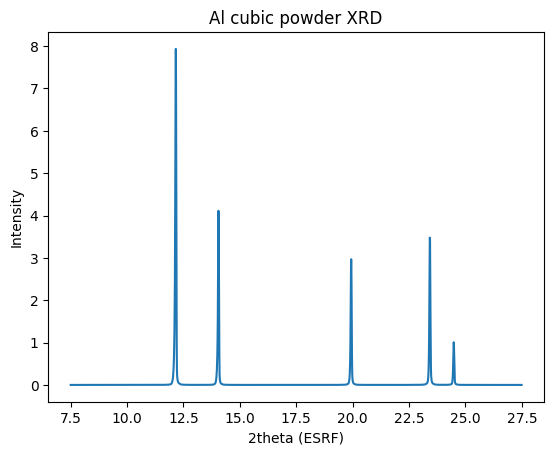

In [ ]:
wavelength = 0.495937

def calculate_d_hkl_cubic(h, k, l, material):
    if h == 0 and k == 0 and l == 0:
        raise ValueError('hkl cannot be 0,0,0')
    return np.sqrt(material.a**2/(h**2 + k**2 + l**2))

def calculate_theta_from_q(q, wavelength):
    return 2*np.arcsin(q * wavelength / (4 * np.pi))*180/np.pi

def calculate_q(d):
    return 2*np.pi/d

def display_q_and_tth(reflections, forbidden_q, q_min=1.98, q_max=6.0):
    d_hkl = calculate_d_hkl_cubic(h, k, l, Al_cubic)
    q = calculate_q(d_hkl)
    theta = calculate_theta_from_q(q, wavelength)

    if q >= q_min and q <= q_max:
        if round(q, 2) in forbidden_q:
            return reflections
        if (h,k,l) not in reflections:
            reflections[(h,k,l)] = {'theta': round(theta, 2), 'q': round(q, 2), "multiplicity": 1}
        else:
            reflections[(h,k,l)]['multiplicity'] += 1
    
    return reflections


reflections = {}
forbidden_q = [3.47, 4.65, 5.59]

for h in range(0, 6):
    for k in range(0, 6):
        for l in range(0, 6):
            if h+k+l == 0:
                continue
            if ((h+k)%2 == 0 and (k+l)%2 == 0 and (l+h)%2 == 0) and h*k*l != 0:
                reflections = display_q_and_tth(reflections, forbidden_q)
            if h == 0 and k%2 == 0 and l%2 == 0:
                reflections = display_q_and_tth(reflections, forbidden_q)
            if h==k and h+l%2 == 0:
                reflections = display_q_and_tth(reflections, forbidden_q)
            if h%2 == 0 and k*l ==0:
                reflections = display_q_and_tth(reflections, forbidden_q)

reflections = dict(sorted(reflections.items(), key=lambda item: item[1]["q"]))


print("h, k, l, theta, q, multiplicity")
for line in reflections:
    print(line, reflections[line]["theta"], reflections[line]["q"], reflections[line]["multiplicity"]) 

# Intensity vs two theta
plt.plot(tt, inte)
plt.title("Al cubic powder XRD")
plt.xlabel("2theta (ESRF)")
plt.ylabel("Intensity")
plt.show()

In [ ]:
delta_q = 0.11
offset_q = 0.15 

count = 0
matching_pos_list = np.zeros(img_data_current_2.shape)

print("Pixels detectées", len(center_coordinate_list))

for x, y in center_coordinate_list:
    if not (x < qx.shape[0] and y < qx.shape[1]):
        continue
    q = calculate_q_norm(qx[y, x], qy[y, x], qz[y, x])
    
    for line in reflections:
        if reflections[line]["q"] < (q+offset_q)+delta_q and reflections[line]["q"] > (q+offset_q)-delta_q:
            count += 1
            print("Found q:", q, "with hkl:", line, " matching with Al_cubic, q=",qx[y, x], qy[y, x], qz[y, x])
            print(x,y)
            matching_pos_list[x, y] = 1
            continue
            

print("Pixels appartenant à la phase Al_cubic", count)

Pixels detectées 237
Found q: 5.074322659967936 with hkl: (1, 1, 3)  matching with Al_cubic, q= -0.5727334369707346 -1.0082239193983698 4.940061881797914
393 1812
Found q: 5.074322659967936 with hkl: (1, 3, 1)  matching with Al_cubic, q= -0.5727334369707346 -1.0082239193983698 4.940061881797914
393 1812
Found q: 5.074322659967936 with hkl: (3, 1, 1)  matching with Al_cubic, q= -0.5727334369707346 -1.0082239193983698 4.940061881797914
393 1812
Found q: 5.074631139620134 with hkl: (1, 1, 3)  matching with Al_cubic, q= -0.5728611471538374 -1.0098998237273848 4.940021624984989
393 1813
Found q: 5.074631139620134 with hkl: (1, 3, 1)  matching with Al_cubic, q= -0.5728611471538374 -1.0098998237273848 4.940021624984989
393 1813
Found q: 5.074631139620134 with hkl: (3, 1, 1)  matching with Al_cubic, q= -0.5728611471538374 -1.0098998237273848 4.940021624984989
393 1813
Found q: 5.0305840672540505 with hkl: (1, 1, 3)  matching with Al_cubic, q= -0.5617879068109284 1.1392783087824547 4.8675677027

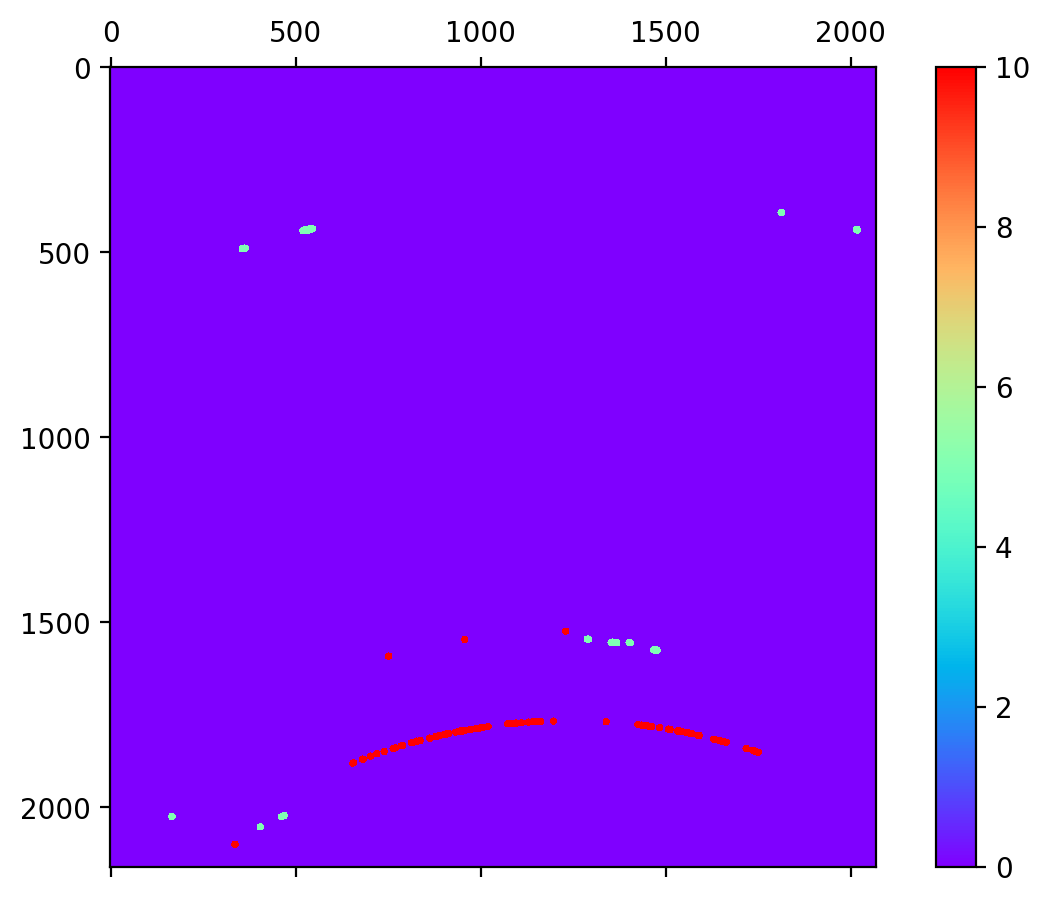

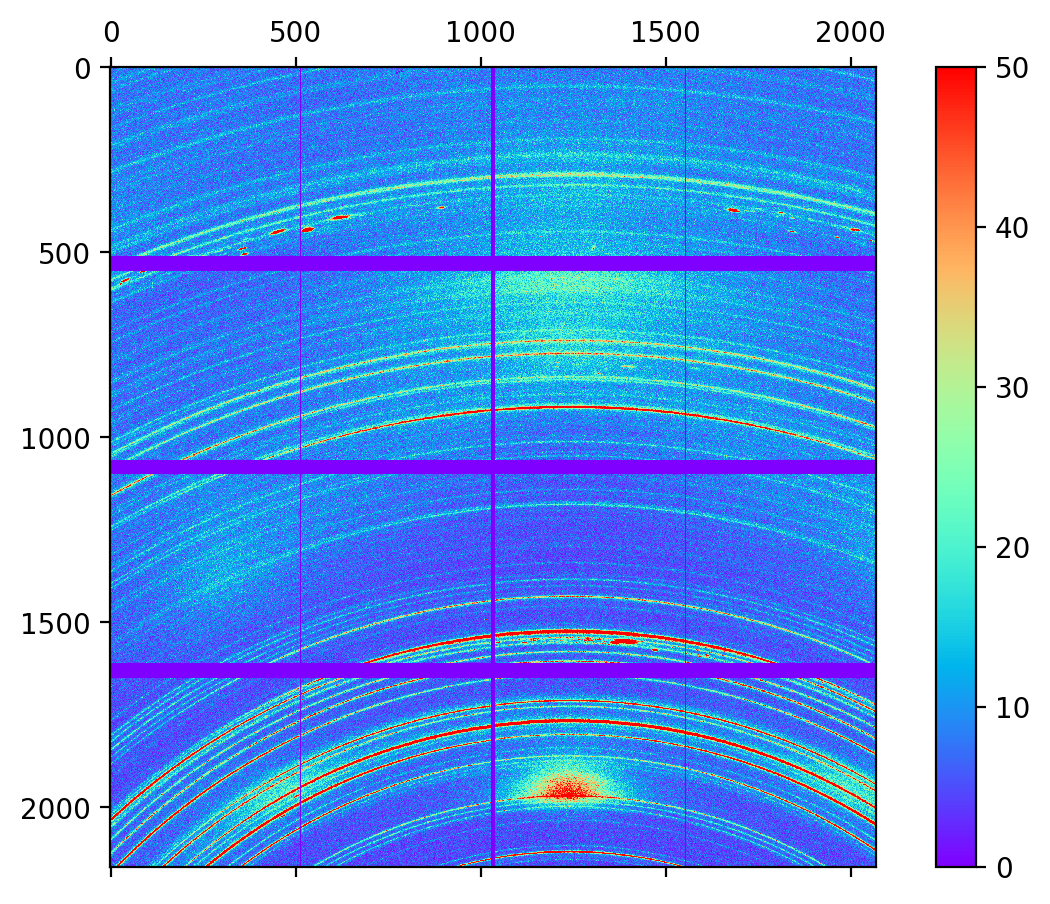

In [ ]:
submask, _ = create_mask(mask, matching_pos_list, value=-5,threshold=0.5)

ee.plot_img('_', '_', img_data=mask+submask, vmin=0, vmax=10, scale="normal", aspect="1")
ee.plot_img('_', '_', img_data=img_data_current_2, vmin=0.0, vmax=50.0, scale="normal", aspect="1")

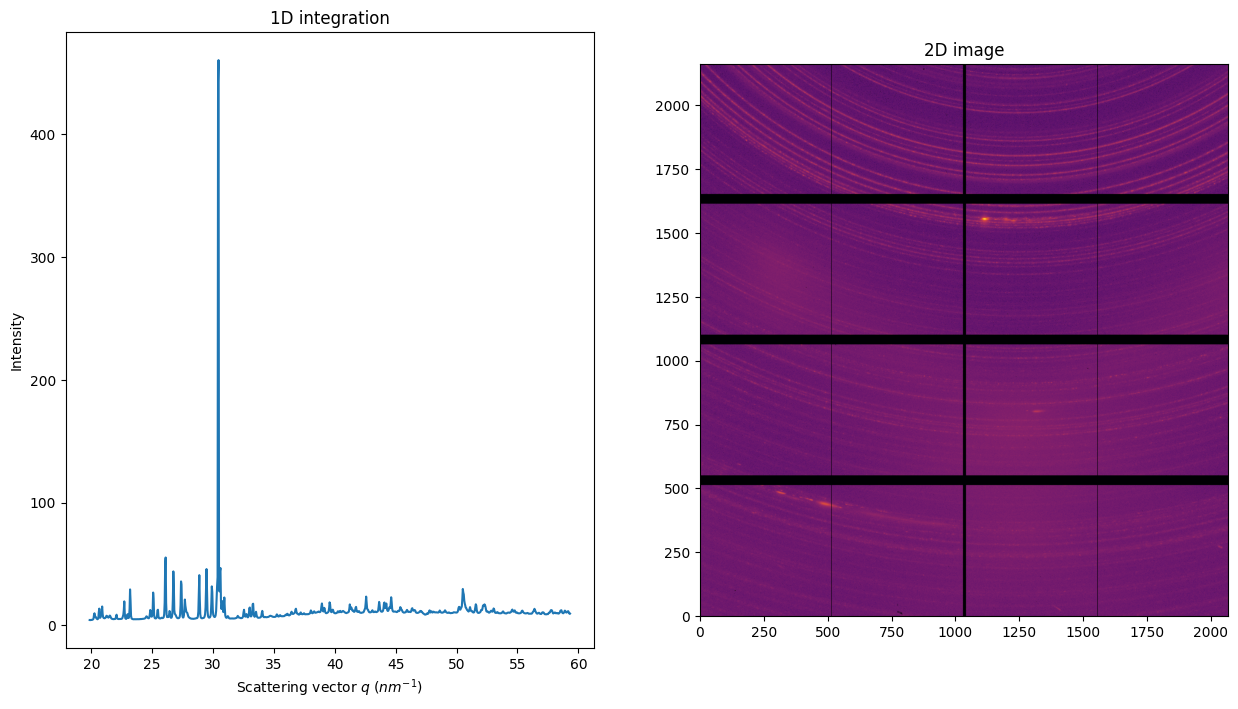

In [27]:
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"]="0"

from matplotlib.pyplot import subplots
from pyFAI.gui import jupyter
import numpy, fabio, pyFAI
from pyFAI import benchmark
from pyFAI.test.utilstest import UtilsTest

ai = pyFAI.load("/Users/williamrigaut/Desktop/Notebooks/Extract_ESRF_Data/ESRF_data/CONFIG/LaB6_25keV_20250501.poni")
#img = fabio.open("/Users/williamrigaut/Desktop/Notebooks/Extract_ESRF_Data/ESRF_data/SAVED_DATA/CeCoX/CeCoZn_4_7/CeCoZn_4_7_117.img").data
img = fabio.open("/Users/williamrigaut/Desktop/Notebooks/Extract_ESRF_Data/ESRF_data/SAVED_DATA/NdXFeB-magnetron/NdCeFeB_2_7/NdCeFeB_2_7_117.img").data

fig, ax = subplots(1, 2)
fig.set_size_inches(15, 8)
jupyter.display(img, ax=ax[1])
plot1d = ai.integrate1d(img, 1000)
jupyter.plot1d(plot1d, ax=ax[0])
ax[1].set_title("2D image")
pass

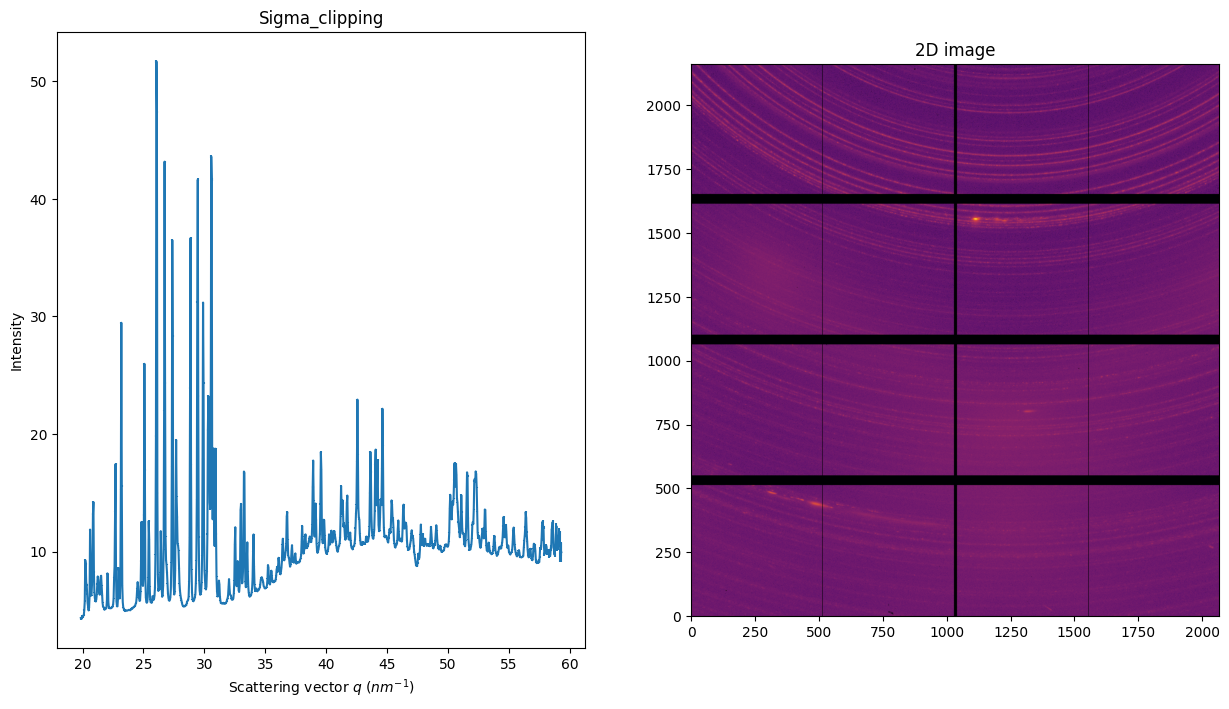

In [ ]:
fig, ax = subplots(1, 2)
fig.set_size_inches(15, 8)
jupyter.display(img, ax=ax[1])
plot1d_corrected_sigma = ai.sigma_clip(img, 1000, error_model="hybrid", method=("no", "csr", "cython"))
jupyter.plot1d(plot1d_corrected_sigma, ax=ax[0])
ax[1].set_title("2D image")
ax[0].set_title("Sigma_clipping")
pass

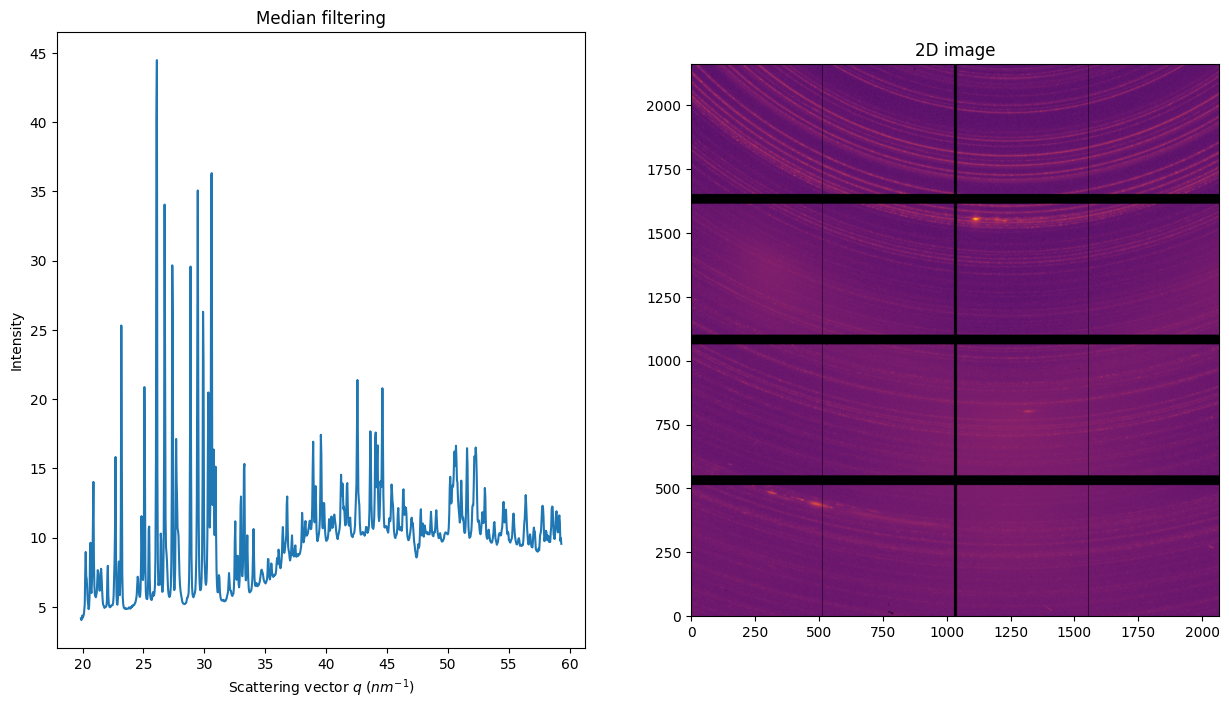

In [ ]:
method = ["full", "csr", "cython"]
percentile=(30,70)
pol=0.99
plot1d_corrected_median = ai.medfilt1d_ng(img, 1000, method=method, percentile=percentile, polarization_factor=pol)

fig, ax = subplots(1, 2)
fig.set_size_inches(15, 8)
jupyter.display(img, ax=ax[1])
jupyter.plot1d(plot1d_corrected_median, ax=ax[0])
ax[1].set_title("2D image")
ax[0].set_title("Median filtering")
pass